In [582]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPool1D, BatchNormalization, Dropout, LSTM, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling,over_sampling
import lightgbm as lgb
from imblearn.over_sampling import SMOTE 


from cv2 import imread, resize

In [583]:
data = pd.read_csv('../input/water-quality/waterQuality1.csv')

data = data.drop('ammonia', axis = 1)
data = data.drop('flouride', axis = 1)
data = data.drop('selenium', axis = 1)
data = data.drop('uranium', axis = 1)

data = data[data['is_safe'] != '#NUM!']
data['is_safe'] = data['is_safe'].astype(int)

columns = dict(zip(list(range(data.shape[1])), data.columns.values.tolist()))
is_safe = data['is_safe']

data = pd.DataFrame(StandardScaler().fit_transform(data)).rename(columns = columns)
data['is_safe'] = is_safe
data = data.dropna()
data.head(6)

,aluminium,arsenic,barium,cadmium,chloramine,chromium,copper,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,silver,is_safe
0,0.777403,-0.480875,1.054205,-0.993241,-0.711941,2.152993,-0.973050,-0.363345,-0.869387,-0.781070,1.129767,-0.348629,0.609178,1.203362,1.661842,1.338736,1.0
1,1.306945,-0.599632,1.432447,-1.131948,1.208552,1.598765,-0.223303,1.002460,0.849782,0.009785,-1.409197,1.046960,-0.739005,0.892977,0.124811,0.851134,1.0
2,0.271572,-0.480875,-0.812340,-0.965499,0.803417,1.044536,-1.202564,-0.818614,-0.861452,-0.368450,0.783298,-0.383518,0.272132,1.911763,1.786699,2.035310,0.0
3,0.548198,-0.480875,1.144654,-1.159690,1.968179,-0.802892,1.306793,1.184567,1.008475,-1.434385,-1.517469,-0.069511,-0.401960,-0.415275,-0.516695,2.104968,1.0
4,0.200439,-0.520460,-1.124801,-1.020982,0.191820,1.635713,-0.361012,-0.575804,-0.866742,0.302058,-0.555658,-0.383518,-0.739005,0.024578,-0.219622,-0.611672,1.0
5,0.216246,-0.520460,1.078873,-1.104207,-0.536643,0.675051,0.878366,1.063162,0.902680,0.611523,-0.012496,0.977180,0.272132,0.605207,1.076306,0.293875,1.0


In [584]:
x = data.drop('is_safe', axis = 1)
y = data['is_safe']

from collections import Counter
from imblearn.over_sampling import SMOTE

counter = Counter(y)
print(counter)




x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 25)

y_train = np.expand_dims(y_train, axis = -1)
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
y_tset = np.expand_dims(x_test, axis = -1)

counter = Counter(y)
print(counter)
print(y_train.shape)
print(x_train.shape)

Counter({0.0: 7084, 1.0: 909})
Counter({0.0: 7084, 1.0: 909})
(6394, 1)
(6394, 16, 1)


Data [is_safe]:  7993
0.0    7084
1.0     909
Name: is_safe, dtype: int64


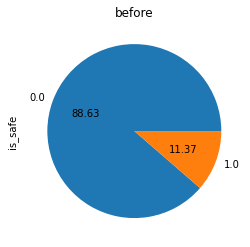

In [585]:
print("Data [is_safe]: ", data.shape[0])
print(y.value_counts())
a=y.value_counts().plot.pie(autopct='%.2f')
_=a.set_title("before")

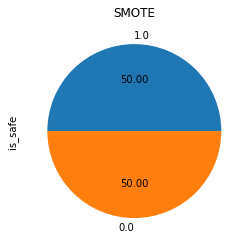

In [586]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)
ax =y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("SMOTE")

In [587]:
model = Sequential()
model.add(Conv1D(64, 3, padding="same",input_shape =(16,1), activation='relu'))
model.add(MaxPool1D(pool_size=(2)))  
model.add(Dropout(0.2))
model.add(Conv1D(64, 3, padding="same",input_shape =(16,1), activation='relu'))
model.add(MaxPool1D(pool_size=(2)))  
model.add(Dropout(0.4))
# model.add(Conv1D(64, 3, padding="same", activation='relu'))
# model.add(MaxPool1D(pool_size=(2)))  
# model.add(Dropout(0.2))
# model.add(Conv1D(64, 3, padding="same", activation='relu'))
# model.add(MaxPool1D(pool_size=(2)))  
# model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dropout(0.5))
# model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

In [588]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')


In [589]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [590]:
history=model.fit(x_train, y_train,
          batch_size=100,
          epochs=150,
          validation_split=0.2,callbacks=[early])

Epoch 1/150
52/52 [==============================] - 1s 11ms/step - loss: 0.8408 - accuracy: 0.6242 - val_loss: 0.4990 - val_accuracy: 0.8827
Epoch 2/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3801 - accuracy: 0.8645 - val_loss: 0.4401 - val_accuracy: 0.8851
Epoch 3/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3463 - accuracy: 0.8766 - val_loss: 0.3933 - val_accuracy: 0.8780
Epoch 4/150
52/52 [==============================] - 0s 6ms/step - loss: 0.3219 - accuracy: 0.8843 - val_loss: 0.3555 - val_accuracy: 0.8765
Epoch 5/150
52/52 [==============================] - 0s 5ms/step - loss: 0.3206 - accuracy: 0.8868 - val_loss: 0.3276 - val_accuracy: 0.8921
Epoch 6/150
52/52 [==============================] - 0s 5ms/step - loss: 0.2936 - accuracy: 0.8925 - val_loss: 0.3002 - val_accuracy: 0.8874
Epoch 7/150
52/52 [==============================] - 0s 6ms/step - loss: 0.2926 - accuracy: 0.8929 - val_loss: 0.2700 - val_accuracy: 0.8905
Epoch 8/150


In [591]:
evaluation = model.evaluate(x_test, y_test, verbose=1)

50/50 [==============================] - 0s 2ms/step - loss: 0.1788 - accuracy: 0.9350


Text(0, 0.5, 'Loss')

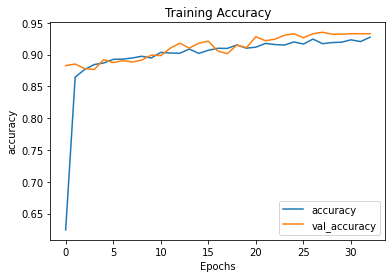

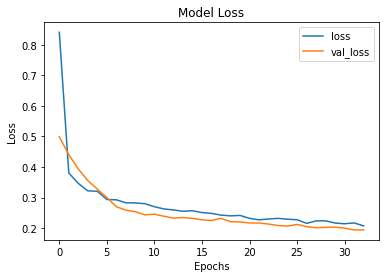

In [592]:
pd.DataFrame(history.history)
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")